# Performance analysis of a uniform linear array

We compare the MSE of MUSIC with the CRB for a uniform linear array (ULA).

In [7]:
import numpy as np
import doatools.plotting as doaplot
import doatools.model as model
import doatools.estimation as estimation
import doatools.performance as perf
import matplotlib.pyplot as plt
# %matplotlib inline

In [8]:
n_snapshots = 300
n_sensors=12
wavelength = 1.0 # normalized
d0 = wavelength / 2
power_source = 1 # Normalized


In [9]:
# We use root-MUSIC.
estimator = estimation.RootMUSIC1D(wavelength)
# Create a 12-element ULA.
ula = model.UniformLinearArray(n_sensors, d0)

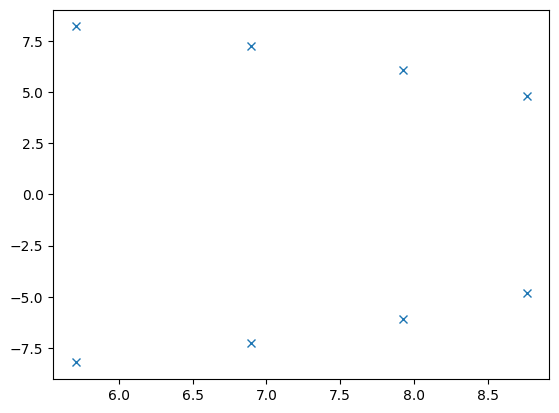

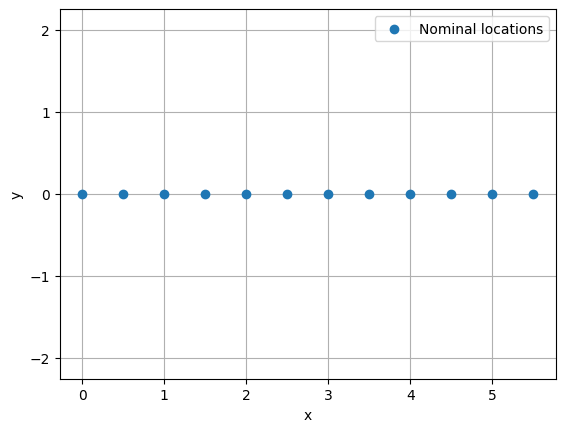

(8, 2)


In [10]:




total_sources=8
n_groups=2
width=0.2*np.pi
edge_position=np.pi/3

sensors_per_ground=total_sources//n_groups
h_matrix=np.zeros([total_sources,n_groups])

h_base=np.ones(sensors_per_ground)+np.linspace(-0.5,0.5,sensors_per_ground)*width
for g in range(n_groups):
    h_matrix[g*sensors_per_ground:(g+1)*sensors_per_ground,g:(g+1)]=h_base.reshape([-1,1])
centers=np.linspace(-edge_position+width/2, edge_position-width/2, n_groups)
rho=np.asarray([centers[0],centers[1]])
theta=h_matrix@rho
h_dagger=np.linalg.inv(h_matrix.T @ h_matrix)@h_matrix.T
sources = model.FarField1DSourcePlacement(
    theta
)

loc=np.asarray([[10*np.cos(doa),10*np.sin(doa)] for doa in sources._locations])

plt.plot(loc[:,0],loc[:,1],'x')
doaplot.plot_array(ula)
plt.show()
print(loc.shape)


# All sources share the same power.
source_signal = model.ComplexStochasticSignal(sources.size, power_source)

We vary the SNR from -20 dB to 20 dB. Here the SNR is defined as:
\begin{equation}
    \mathrm{SNR} = 10\log_{10}\frac{\min_i p_i}{\sigma^2_{\mathrm{n}}},
\end{equation}
where $p_i$ is the power of the $i$-th source, and $\sigma^2_{\mathrm{n}}$ is the noise power.

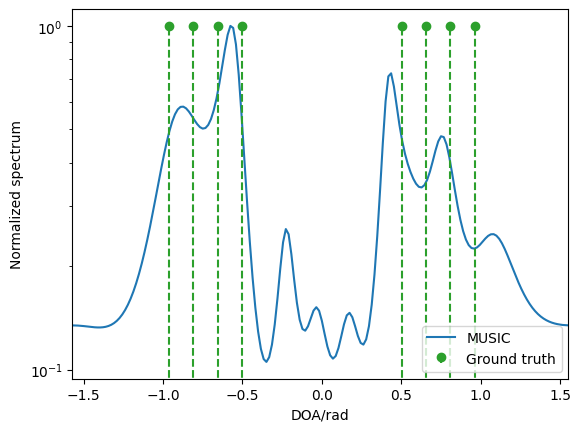

Completed SNR = -20.00 dB


<Figure size 640x480 with 0 Axes>

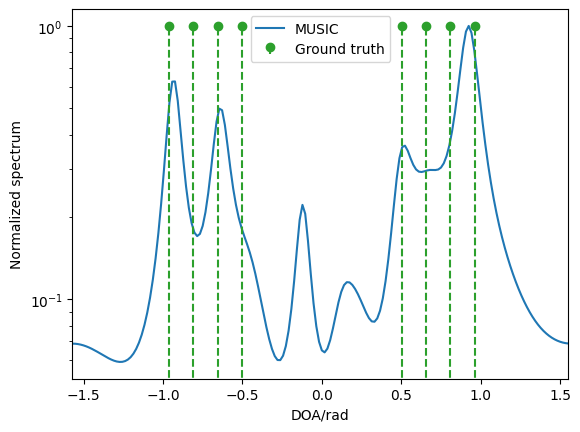

Completed SNR = -17.89 dB


<Figure size 640x480 with 0 Axes>

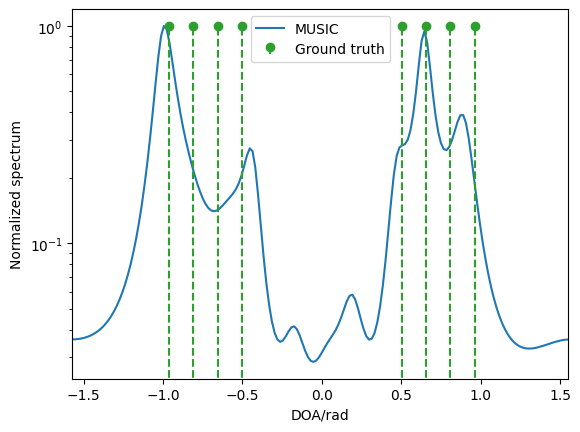

Completed SNR = -15.79 dB


<Figure size 640x480 with 0 Axes>

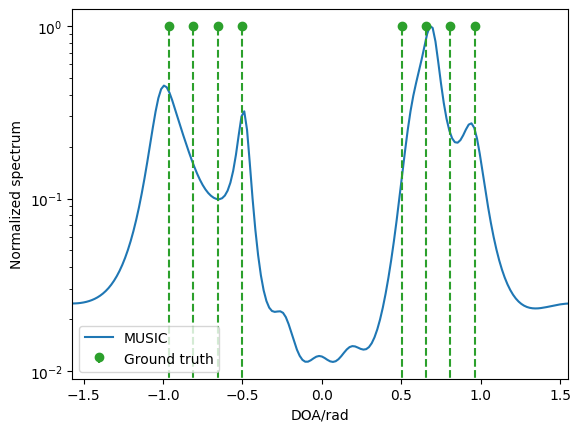

Completed SNR = -13.68 dB


<Figure size 640x480 with 0 Axes>

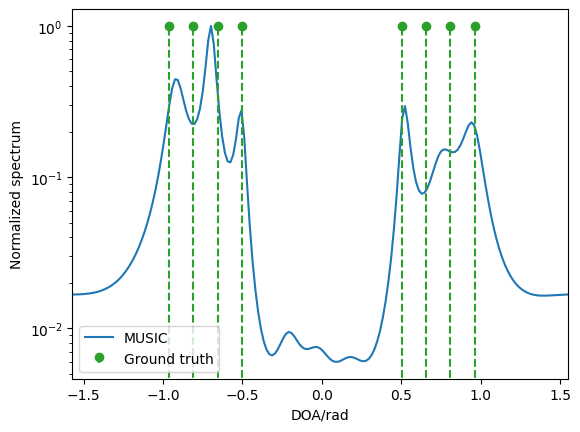

Completed SNR = -11.58 dB


<Figure size 640x480 with 0 Axes>

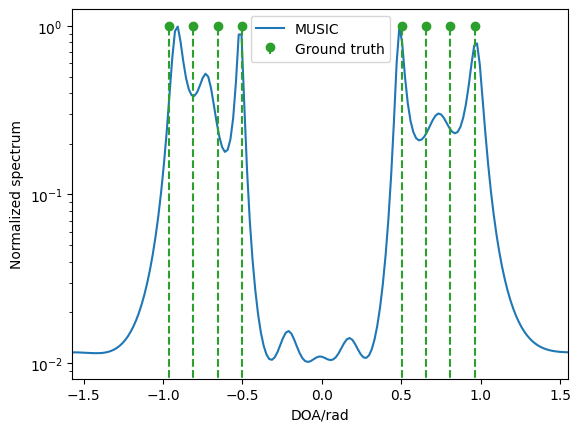

Completed SNR = -9.47 dB


<Figure size 640x480 with 0 Axes>

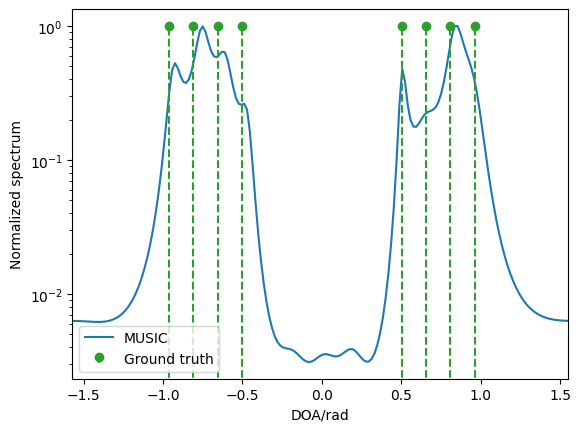

Completed SNR = -7.37 dB


<Figure size 640x480 with 0 Axes>

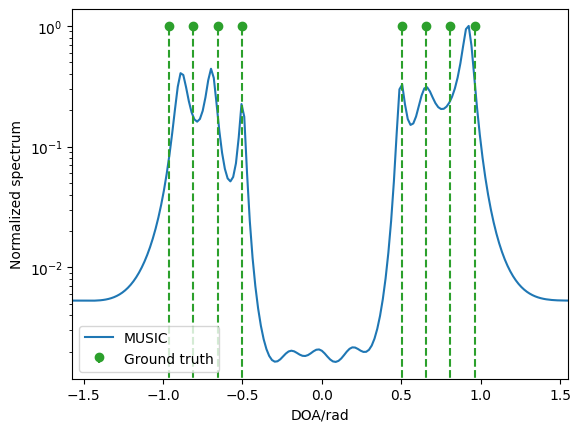

Completed SNR = -5.26 dB


<Figure size 640x480 with 0 Axes>

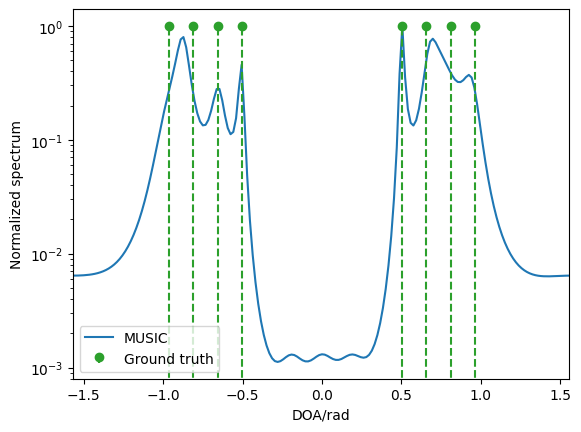

Completed SNR = -3.16 dB


<Figure size 640x480 with 0 Axes>

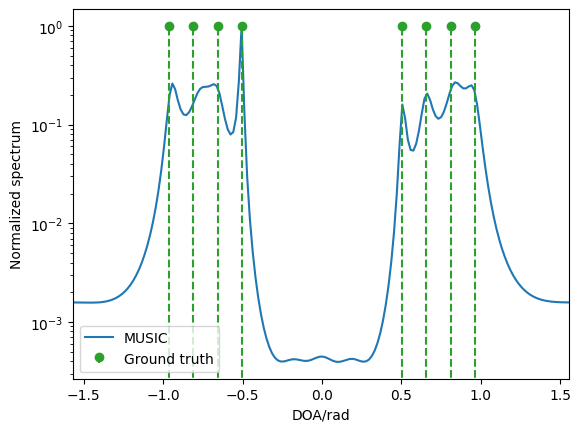

Completed SNR = -1.05 dB


<Figure size 640x480 with 0 Axes>

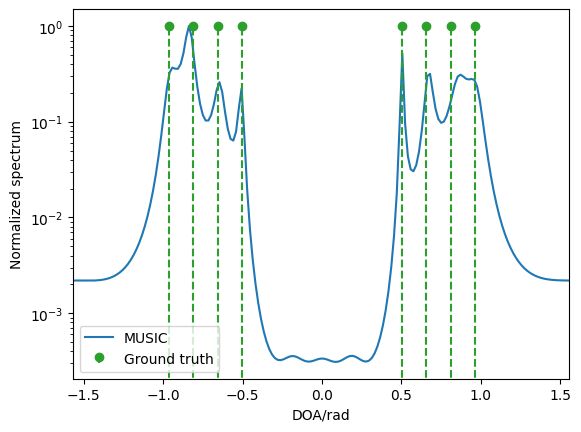

Completed SNR = 1.05 dB


<Figure size 640x480 with 0 Axes>

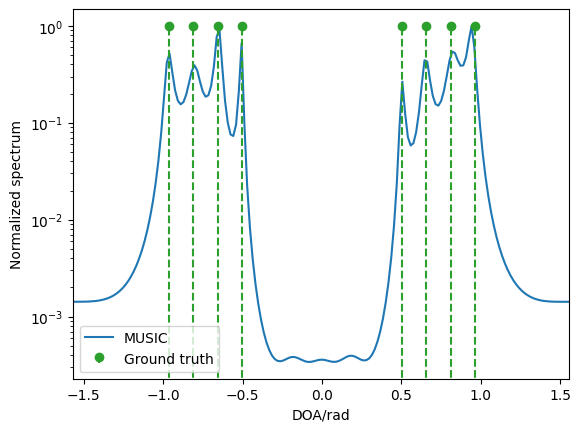

Completed SNR = 3.16 dB


<Figure size 640x480 with 0 Axes>

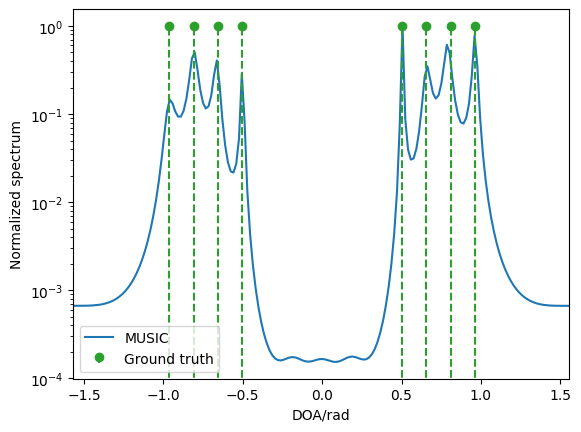

Completed SNR = 5.26 dB


<Figure size 640x480 with 0 Axes>

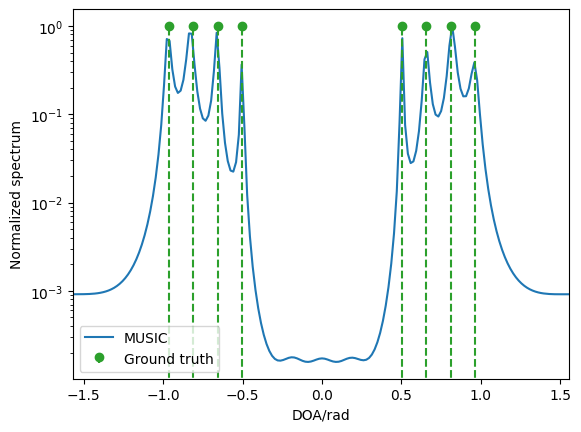

Completed SNR = 7.37 dB


<Figure size 640x480 with 0 Axes>

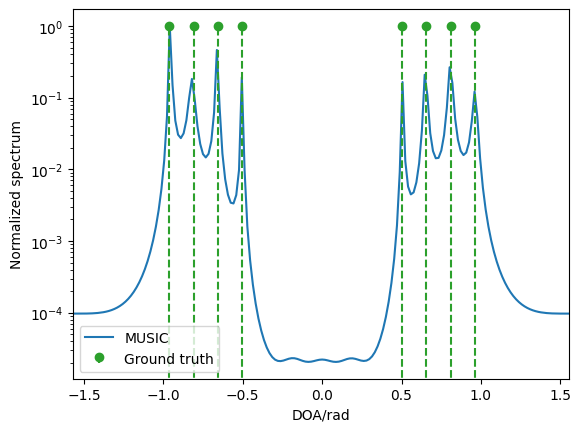

Completed SNR = 9.47 dB


<Figure size 640x480 with 0 Axes>

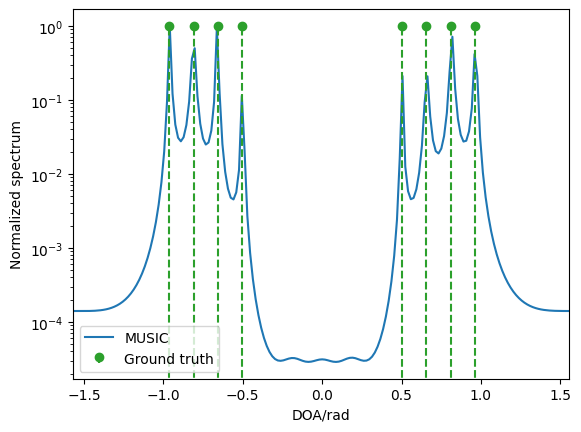

Completed SNR = 11.58 dB


<Figure size 640x480 with 0 Axes>

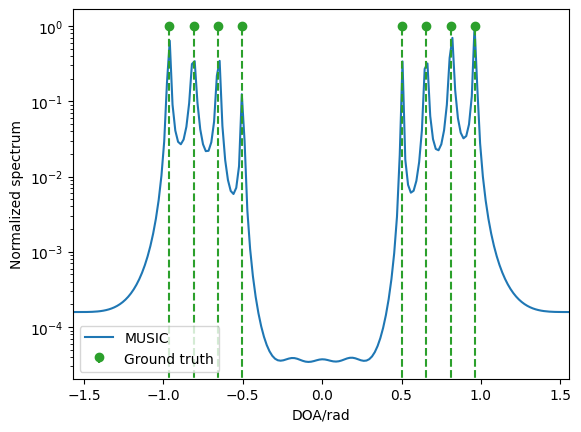

Completed SNR = 13.68 dB


<Figure size 640x480 with 0 Axes>

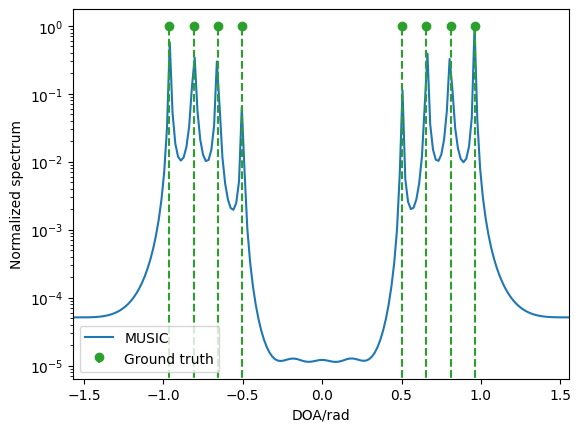

Completed SNR = 15.79 dB


<Figure size 640x480 with 0 Axes>

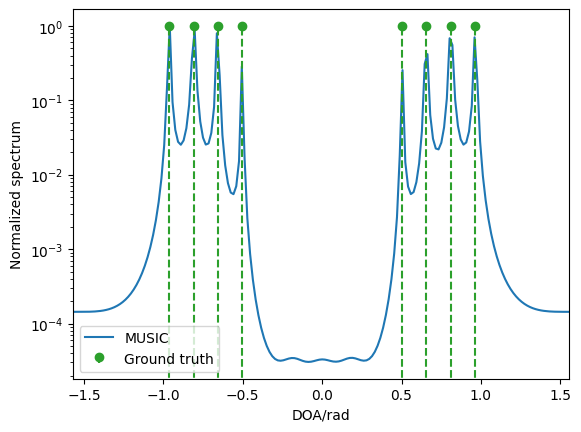

Completed SNR = 17.89 dB


<Figure size 640x480 with 0 Axes>

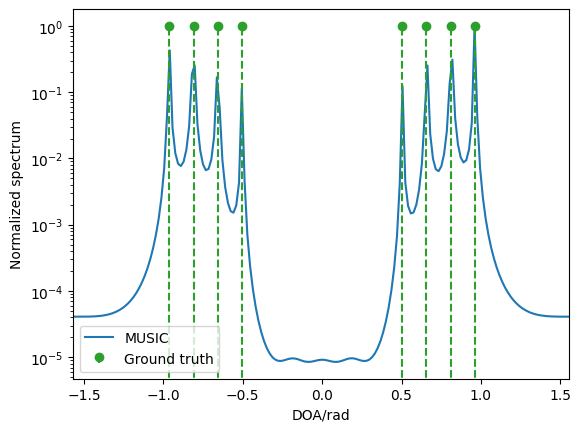

Completed SNR = 20.00 dB


<Figure size 640x480 with 0 Axes>

In [5]:
snrs = np.linspace(-20, 20, 20)
# 300 Monte Carlo runs for each SNR
n_repeats = 1000

mses = np.zeros((len(snrs),))
mses_rho = np.zeros((len(snrs),))
crbs_b1 = np.zeros((len(snrs),))
crbs_b2 = np.zeros((len(snrs),))
crbs_det = np.zeros((len(snrs),))
crbs_stouc = np.zeros((len(snrs),))
S = source_signal.emit(n_snapshots)
Rs = (S @ S.conj().T) / n_snapshots
A = ula.steering_matrix(sources, wavelength)
for i, snr in enumerate(snrs):
    power_noise = power_source / (10**(snr / 10))
    noise_signal = model.ComplexStochasticSignal(ula.size, power_noise)
    # The squared errors and the deterministic CRB varies
    # for each run. We need to compute the average.
    cur_mse = 0.0
    cur_crb_det = 0.0
    cur_mse_rho = 0.0

    for r in range(n_repeats):
        # Stochastic signal model.
        N = noise_signal.emit(n_snapshots)
        Y = A @ S + N
        Ry = (Y @ Y.conj().T) / n_snapshots
        resolved, estimates = estimator.estimate(Ry, sources.size, d0)
        if r==0:
            # Get the estimated covariance matrix.
            _, R = model.get_narrowband_snapshots(ula, sources, wavelength, source_signal, noise_signal,
                                      n_snapshots, return_covariance=True)    
            # Create a MUSIC-based estimator.
            grid = estimation.FarField1DSearchGrid()
            estimator_music = estimation.MUSIC(ula, wavelength, grid)

            # Get the estimates.
            _, _, sp = estimator_music.estimate(R, sources.size, return_spectrum=True)

            # Plot the MUSIC-spectrum.
            doaplot.plot_spectrum({'MUSIC': sp}, grid, ground_truth=sources, use_log_scale=True);
            plt.savefig("music_{snr}.svg")


        # In practice, you should check if `resolved` is true.
        # We skip the check here.
        cur_mse += np.mean((estimates.locations - sources.locations)**2)
        cur_mse_rho+=np.mean((h_dagger @ estimates.locations - rho)**2)

        # B_det = perf.ecov_music_1d(ula, sources, wavelength, Rs, power_noise,
        #                            n_snapshots)
        # cur_crb_det += np.mean(np.diag(B_det))
    # Update the results.
    B_det,FIM = perf.crb_det_farfield_1d(ula, sources, wavelength, Rs,
                                     power_noise, n_snapshots)
    B1 = np.linalg.inv(h_matrix.T @ FIM @ h_matrix)
    B2= h_dagger @ B_det @ h_dagger.T
    mses[i] = cur_mse / n_repeats
    mses_rho[i] = cur_mse_rho / n_repeats
    crbs_b1[i] = np.mean(np.diag(B1))
    crbs_b2[i] = np.mean(np.diag(B2))
    print('Completed SNR = {0:.2f} dB'.format(snr))

We plot the results below.

* The MSE should approach the stochastic CRBs in high SNR regions.
* The stochastic CRB should be tighter than the deterministic CRB.
* With the additional assumption of uncorrelated sources, we expect a even lower CRB.
* All three CRBs should converge together as the SNR approaches infinity.

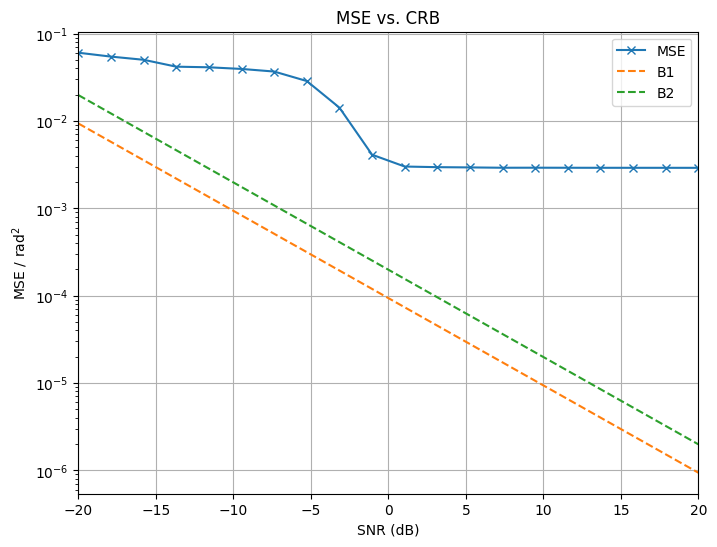

In [6]:
plt.figure(figsize=(8, 6))
plt.semilogy(
    snrs, mses_rho, '-x',
    # snrs, crbs_sto, '--',
    snrs, crbs_b1, '--',
    snrs, crbs_b2, '--',
    # snrs, crbs_stouc, '--'
)
plt.xlabel('SNR (dB)')
plt.ylabel(r'MSE / $\mathrm{rad}^2$')
plt.grid(True)
plt.legend(['MSE','B1','B2'])
plt.title('MSE vs. CRB')
plt.margins(x=0)
plt.show()